# 04. PyTorch Custom Datasets Exercises

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

1.13.1+cu117


## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

There are many ways of handling the issue of underfitting. Some of these are:
- Increasing model complexity: It could be the case that the model is too simple for the job, resulting in poor performance as patterns are not properly identified.
- Remove noise from, or add noise to data: The data could contain samples that are of poor quality or that don't match at all (e.g., an image of pizza in the sushi dataset). On the flipside, the model could also be lacking in data variety, which could benefit from some added noise.
- Regularization: A wide variety of technies with the goal of introducing a  a “complexity penalty” to the model. If the model wants to avoid incurring that penalty, it needs to focus on the most prominent patterns which have a better chance of generalizing well.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [2]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
# Setup train and testing paths
from pathlib import Path

IMAGE_PATH = Path("data/PizzaSteakSushi")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

In [4]:
# Loading data
image_path_list = list(IMAGE_PATH.glob("*/*/*.jpg"))

Class: steak, Dimensions:512x512


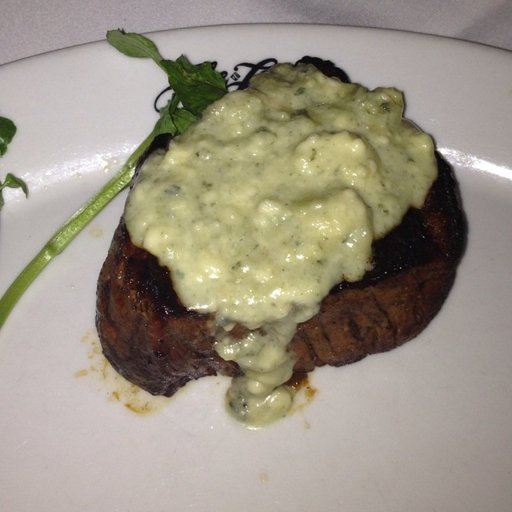

In [5]:
# Visualize an image
from PIL import Image
import random

rnd_img_path = random.choice(image_path_list)
img_class = rnd_img_path.parent.stem
img = Image.open(rnd_img_path)
print(f"Class: {img_class}, Dimensions:{img.width}x{img.height}")
img

Class: steak, Dimensions:(512, 512, 3)


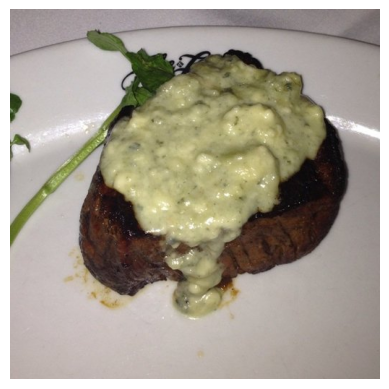

In [6]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.imshow(img_as_array)
print(f"Class: {img_class}, Dimensions:{img_as_array.shape}")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [7]:
from torchvision import datasets, transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [8]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    rnd_img_paths = random.sample(image_paths, k=n)
    for path in rnd_img_paths:
        with Image.open(path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Recall that matplotlib expects colour channels last
            # Permute allows for the colour channels to be moved to the end of the tensor
            trns_f = transform(f).permute(1, 2, 0)
            ax[1].imshow(trns_f)
            ax[1].set_title(f"Transformed\nSize: {trns_f.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {path.parent.stem}", fontsize=14)

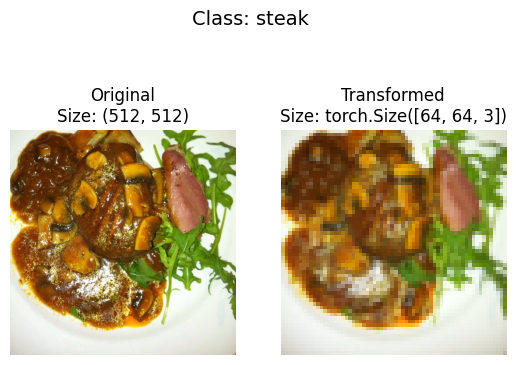

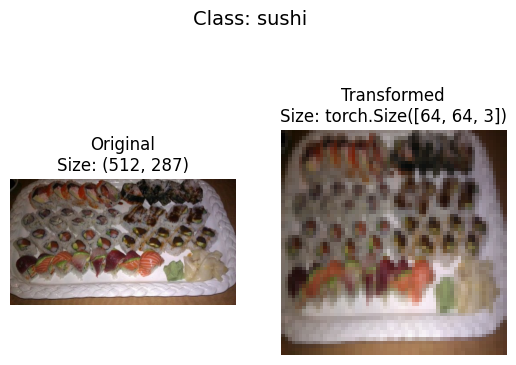

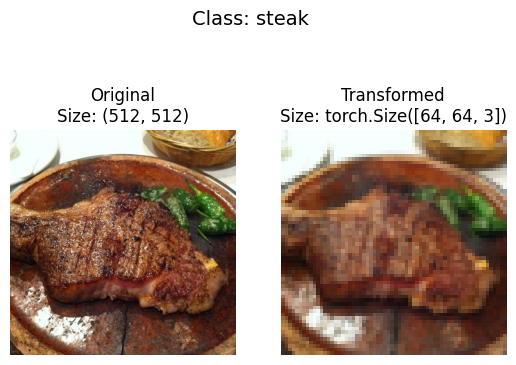

In [9]:
plot_transformed_images(image_path_list, simple_transform, 3)

### Load image data using `ImageFolder`

In [10]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=simple_transform)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=simple_transform)

In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [14]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import Dataset, DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [15]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [16]:
class TinyVGG(nn.Module):
    def __init__(self, in_shape: int, hidden: int, out_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*13*13, out_features=out_shape)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [17]:
model_0 = TinyVGG(in_shape=3, hidden=10, out_shape=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [18]:
def train_step(model, dataloader, loss_fn, optimizer, metric_fn):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in dataloader:
        # 1. Forward pass
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        # 3. Optimizer zero grad 
        optimizer.zero_grad()
        # 4. Loss backward 
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model, dataloader, loss_fn, metric_fn): 
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in dataloader:
            # 1. Forward pass
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            # 2. Calculuate and accumulate loss
            test_loss += loss_fn(test_logits, y)
            # 3. Calculate and accumulate accuracy
            test_acc += metric_fn(test_pred, y)
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        return test_loss, test_acc

In [20]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, epochs):
    # Create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # Loop through the training and testing steps for a number of epochs
    for epoch in (range(epochs)):
        # Train step
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           metric_fn=metric_fn)
        # Test step
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        metric_fn=metric_fn)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.5f} | "
              f"train_acc: {train_acc:.2f} | "
              f"test_loss: {test_loss:.5f} | "
              f"test_acc: {test_acc:.2f}")

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results dictionary
    return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [21]:
from torchmetrics import Accuracy

In [22]:
loss_fn = nn.CrossEntropyLoss()
metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [23]:
# Train for 5 epochs
torch.manual_seed(42)
model_0 = TinyVGG(in_shape=3, hidden=10, out_shape=len(class_names))
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
model_0_results = train(model_0, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, 5)

Epoch: 1 | train_loss: 1.10632 | train_acc: 0.30 | test_loss: 1.09832 | test_acc: 0.30
Epoch: 2 | train_loss: 1.09982 | train_acc: 0.33 | test_loss: 1.06968 | test_acc: 0.54
Epoch: 3 | train_loss: 1.08686 | train_acc: 0.49 | test_loss: 1.08074 | test_acc: 0.49
Epoch: 4 | train_loss: 1.08421 | train_acc: 0.40 | test_loss: 1.06084 | test_acc: 0.58
Epoch: 5 | train_loss: 1.06622 | train_acc: 0.41 | test_loss: 1.06541 | test_acc: 0.56


In [24]:
# Train for 20 epochs
torch.manual_seed(42)
model_1 = TinyVGG(in_shape=3, hidden=10, out_shape=len(class_names))
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
model_1_results = train(model_1, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, 20)

Epoch: 1 | train_loss: 1.10632 | train_acc: 0.30 | test_loss: 1.09832 | test_acc: 0.30
Epoch: 2 | train_loss: 1.09982 | train_acc: 0.33 | test_loss: 1.06968 | test_acc: 0.54
Epoch: 3 | train_loss: 1.08686 | train_acc: 0.49 | test_loss: 1.08074 | test_acc: 0.49
Epoch: 4 | train_loss: 1.08421 | train_acc: 0.40 | test_loss: 1.06084 | test_acc: 0.58
Epoch: 5 | train_loss: 1.06622 | train_acc: 0.41 | test_loss: 1.06541 | test_acc: 0.56
Epoch: 6 | train_loss: 1.02977 | train_acc: 0.44 | test_loss: 1.01328 | test_acc: 0.54
Epoch: 7 | train_loss: 0.98096 | train_acc: 0.42 | test_loss: 0.93111 | test_acc: 0.61
Epoch: 8 | train_loss: 0.95656 | train_acc: 0.59 | test_loss: 1.01058 | test_acc: 0.47
Epoch: 9 | train_loss: 0.92433 | train_acc: 0.60 | test_loss: 1.06996 | test_acc: 0.34
Epoch: 10 | train_loss: 1.00070 | train_acc: 0.46 | test_loss: 1.05463 | test_acc: 0.40
Epoch: 11 | train_loss: 0.87217 | train_acc: 0.52 | test_loss: 0.97023 | test_acc: 0.49
Epoch: 12 | train_loss: 0.93093 | train_a

In [25]:
# Train for 50 epochs
torch.manual_seed(42)
model_2 = TinyVGG(in_shape=3, hidden=10, out_shape=len(class_names))
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
model_2_results = train(model_2, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, 50)

Epoch: 1 | train_loss: 1.10632 | train_acc: 0.30 | test_loss: 1.09832 | test_acc: 0.30
Epoch: 2 | train_loss: 1.09982 | train_acc: 0.33 | test_loss: 1.06968 | test_acc: 0.54
Epoch: 3 | train_loss: 1.08686 | train_acc: 0.49 | test_loss: 1.08074 | test_acc: 0.49
Epoch: 4 | train_loss: 1.08421 | train_acc: 0.40 | test_loss: 1.06084 | test_acc: 0.58
Epoch: 5 | train_loss: 1.06622 | train_acc: 0.41 | test_loss: 1.06541 | test_acc: 0.56
Epoch: 6 | train_loss: 1.02977 | train_acc: 0.44 | test_loss: 1.01328 | test_acc: 0.54
Epoch: 7 | train_loss: 0.98096 | train_acc: 0.42 | test_loss: 0.93111 | test_acc: 0.61
Epoch: 8 | train_loss: 0.95656 | train_acc: 0.59 | test_loss: 1.01058 | test_acc: 0.47
Epoch: 9 | train_loss: 0.92433 | train_acc: 0.60 | test_loss: 1.06996 | test_acc: 0.34
Epoch: 10 | train_loss: 1.00070 | train_acc: 0.46 | test_loss: 1.05463 | test_acc: 0.40
Epoch: 11 | train_loss: 0.87217 | train_acc: 0.52 | test_loss: 0.97023 | test_acc: 0.49
Epoch: 12 | train_loss: 0.93093 | train_a

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [26]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(in_shape=3, hidden=20, out_shape=len(class_names))
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)
model_3_results = train(model_3, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, 20)

Epoch: 1 | train_loss: 1.10314 | train_acc: 0.29 | test_loss: 1.10128 | test_acc: 0.20
Epoch: 2 | train_loss: 1.10159 | train_acc: 0.29 | test_loss: 1.10195 | test_acc: 0.20
Epoch: 3 | train_loss: 1.09987 | train_acc: 0.25 | test_loss: 1.08959 | test_acc: 0.50
Epoch: 4 | train_loss: 1.11133 | train_acc: 0.30 | test_loss: 1.09241 | test_acc: 0.26
Epoch: 5 | train_loss: 1.09500 | train_acc: 0.45 | test_loss: 1.10061 | test_acc: 0.26
Epoch: 6 | train_loss: 1.09517 | train_acc: 0.49 | test_loss: 1.10185 | test_acc: 0.25
Epoch: 7 | train_loss: 1.08595 | train_acc: 0.54 | test_loss: 1.10748 | test_acc: 0.28
Epoch: 8 | train_loss: 1.08851 | train_acc: 0.33 | test_loss: 1.12496 | test_acc: 0.29
Epoch: 9 | train_loss: 1.02195 | train_acc: 0.51 | test_loss: 1.14770 | test_acc: 0.27
Epoch: 10 | train_loss: 1.14363 | train_acc: 0.36 | test_loss: 1.11373 | test_acc: 0.28
Epoch: 11 | train_loss: 1.03878 | train_acc: 0.54 | test_loss: 1.03201 | test_acc: 0.51
Epoch: 12 | train_loss: 1.01104 | train_a

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [27]:
IMAGE_PATH = Path("data/PizzaSteakSushi20Percent")

In [28]:
# See how many images we have
walk_through_dir(IMAGE_PATH)

There are 2 directories and 0 images in 'data\PizzaSteakSushi20Percent'.
There are 3 directories and 0 images in 'data\PizzaSteakSushi20Percent\test'.
There are 0 directories and 46 images in 'data\PizzaSteakSushi20Percent\test\pizza'.
There are 0 directories and 58 images in 'data\PizzaSteakSushi20Percent\test\steak'.
There are 0 directories and 46 images in 'data\PizzaSteakSushi20Percent\test\sushi'.
There are 3 directories and 0 images in 'data\PizzaSteakSushi20Percent\train'.
There are 0 directories and 154 images in 'data\PizzaSteakSushi20Percent\train\pizza'.
There are 0 directories and 146 images in 'data\PizzaSteakSushi20Percent\train\steak'.
There are 0 directories and 150 images in 'data\PizzaSteakSushi20Percent\train\sushi'.


In [29]:
# Create the train and test paths
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

TRAIN_DIR, TEST_DIR

(WindowsPath('data/PizzaSteakSushi20Percent/train'),
 WindowsPath('data/PizzaSteakSushi20Percent/test'))

In [30]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data = ImageFolder(root=TRAIN_DIR, transform=simple_transform)
test_data = ImageFolder(root=TEST_DIR, transform=simple_transform)

# Create dataloaders
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [31]:
# Train a model with increased amount of data
torch.manual_seed(42)
model_4 = TinyVGG(in_shape=3, hidden=20, out_shape=len(class_names))
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)
model_4_results = train(model_4, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, 20)

Epoch: 1 | train_loss: 1.10127 | train_acc: 0.35 | test_loss: 1.09516 | test_acc: 0.43
Epoch: 2 | train_loss: 1.09919 | train_acc: 0.35 | test_loss: 1.06629 | test_acc: 0.36
Epoch: 3 | train_loss: 1.03346 | train_acc: 0.50 | test_loss: 0.98644 | test_acc: 0.51
Epoch: 4 | train_loss: 0.94223 | train_acc: 0.59 | test_loss: 0.97188 | test_acc: 0.47
Epoch: 5 | train_loss: 0.89358 | train_acc: 0.58 | test_loss: 0.93629 | test_acc: 0.56
Epoch: 6 | train_loss: 0.87521 | train_acc: 0.62 | test_loss: 0.93771 | test_acc: 0.56
Epoch: 7 | train_loss: 0.86774 | train_acc: 0.62 | test_loss: 0.95080 | test_acc: 0.59
Epoch: 8 | train_loss: 0.89931 | train_acc: 0.59 | test_loss: 0.99369 | test_acc: 0.54
Epoch: 9 | train_loss: 0.87725 | train_acc: 0.59 | test_loss: 0.93866 | test_acc: 0.59
Epoch: 10 | train_loss: 0.77814 | train_acc: 0.67 | test_loss: 0.98909 | test_acc: 0.54
Epoch: 11 | train_loss: 0.79344 | train_acc: 0.68 | test_loss: 0.92142 | test_acc: 0.59
Epoch: 12 | train_loss: 0.77311 | train_a

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [32]:
custom_image_path = Path("images/04_pizza.jpg")
custom_image = Image.open(custom_image_path)
custom_image_transformed = simple_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [33]:
model_4.eval()
with torch.inference_mode():
    custom_logit = model_4(custom_image_transformed.unsqueeze(0))
    custom_pred = torch.softmax(custom_logit, dim=1).argmax(dim=1)
    print(custom_pred)

tensor([2])


In [34]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

The predicted result is wrong as sushi is predicted whereas the custom image is that of a pizza. Comparing the results of step 6 and 7, the increase in data does cause a sharper growth in training and testing accuracy. However, the testing accuracy remains stuck at around 50-60%. This makes it understandable that wrong predictions tend to happen. Further increases in data quantity may improve the results even more. In addition, it would be wise to check datasets for faulty images. While working on `04_pytorch_custom_datasets.ipynb`, an image of fries and a burger was found in one of the datasets. It's also worth to check out `transforms.TrivialAugmentWide` again in an attempt to improve data variety. It's also worth to explore whether the model gets confused on pizza and sushi more often, as both food types tend to contain circular elements (pepperoni on pizza).